In [10]:
from matplotlib import pyplot as plt
import requests
import cv2
import time
import re

In [3]:
base = 'https://westcentralus.api.cognitive.microsoft.com/vision/v2.0'
recog_url = f'{base}/recognizeText?mode=Printed'
key = '6023f2c1af9e45fd82ed220de33ba475'
headers = {'Ocp-Apim-Subscription-Key': key}                           
headers_stream = {'Ocp-Apim-Subscription-Key': key,                    
                  'Content-Type': 'application/octet-stream'}  

In [8]:
def get_license(img):
    img_encode = cv2.imencode('.jpg', img)[1]       # 將 img 編碼為 jpg 格式，[1]返回資料, [0]返回是否成功
    img_bytes = img_encode.tobytes()                # 再將資料轉為 bytes, 此即為要傳送的資料
    r1 = requests.post(recog_url,            # 發出 POST 
                              headers = headers_stream, 
                              data = img_bytes)
    if r1.status_code != 202:                # 202 代表接受請求
        print(r1.json())
        return '請求失敗'
    #--↓↓辨識請求成功↓↓--#
    result_url = r1.headers['Operation-Location'] # 取得查看結果的請求路徑
    r2 = requests.get(result_url, headers = headers) # 發出 GET 請求
    while r2.status_code == 200 and r2.json()['status'] != 'Succeeded':
        r2 = requests.get(result_url, headers = headers)    # 繼續發出 GET
        time.sleep(0.5)
        print('status: ', r2.json()['status'])     
    #--↓↓辨識完成↓↓--#
    carcard = ''  # 紀錄車牌
    lines = r2.json()['recognitionResult']['lines']
    for i in range(len(lines)):
        text = lines[i]['text'] # 取得辨識文字
        m = re.match(r'^[\w]{2,4}[-. ][\w]{2,4}$', text)    # 匹配是否為車牌格式
        if m != None:   # 匹配成功
            carcard = m.group()
            return carcard
    if carcard == '':   # 
        return '找不到車牌'

status:  Start
車牌： AM 8806


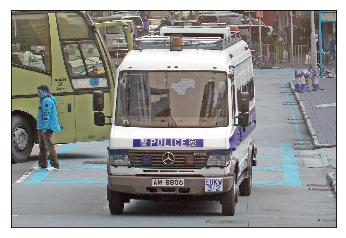

In [9]:
try:
    img = cv2.imread('car5.jpg') 
    print('status:  Start')
    text = get_license(img)      
    print('車牌：', text)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  
    plt.show()
    cv2.waitKey(0)              
    cv2.destroyAllWindows()    
except:
    print('讀取圖片失敗')
